In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.decomposition import PCA
from pandas.api.types import CategoricalDtype

In [16]:
# Leer el JSON
df_91_20 = pd.read_json('df_91_20.json', orient='records', lines=True)
df_91_20.head()

,Estación,Mes,Precipitación,Prec. > a 1.0 mm,Humedad relativa,Nubosidad total,Viento,Temperatura,Temperatura Máx.,Temperatura Mín.,Viento_medido
0,AEROPARQUE AERO,Abr,108.3,6.6,73.6,3.5,13.9,18.5,22.0,15.3,True
1,AEROPARQUE AERO,Ago,61.5,5.0,73.6,3.9,14.0,12.9,16.5,9.7,True
2,AEROPARQUE AERO,Dic,112.8,6.6,65.1,3.2,15.9,23.2,27.4,19.2,True
3,AEROPARQUE AERO,Ene,117.5,6.7,67.0,3.1,16.8,24.5,28.4,20.8,True
4,AEROPARQUE AERO,Feb,112.3,6.0,69.8,3.2,15.8,23.7,27.3,20.2,True


---
## Variable Target

Para abordar el problema como una tarea de clasificación,consideraremos la temperatura media anual de cada estación, representada por la variable 'Temperatura'. A partir de su valor crearemos una variable categórica que represente el clima de cada estación y que será la variable target:

Frías: promedio menor a 10 °C

Templadas frescas: entre 10 °C y 15 °C

Templadas cálidas: entre 15 °C y 20 °C

Cálidas: promedio mayor a 20 °C

Esta clasificación busca representar de manera más precisa la variabilidad climática del país. A continuación, se agruparon las observaciones por estación y se asignó una etiqueta a cada una según el promedio de temperatura.

In [ ]:
# Agrupamos por estación y calculamos el promedio de temperatura de cada una considerando todos los meses y años
df_temperatura_estacion = df_91_20.groupby("Estación")["Temperatura"].mean().reset_index()

# Creamos la variable target

def clasificar_temp(temperatura):
    if temperatura < 10:
        return "fría"
    elif temperatura < 15:
        return "templada fresca"
    elif temperatura < 20:
        return "templada cálida"
    else:
        return "cálida"

df_temperatura_estacion["CLASE"] = df_temperatura_estacion["Temperatura"].apply(clasificar_temp)

# Agregamos por estación todas las variables numéricas
df_agregado = df_91_20.groupby("Estación").mean(numeric_only=True).reset_index()

# Mergeamos con las clases y eliminamos columnas de temperatura y el booleano de "viento_medido". 
# También eliminamos la columna "Estación" porque los nombres de las estaciones no son relevantes para el modelo.
df_final = pd.merge(df_agregado, df_temperatura_estacion[["Estación", "CLASE"]], on="Estación")
df_final = df_final.drop(columns=["Temperatura", "Temperatura Máx.", "Temperatura Mín.", "Viento_medido", "Estación"])

In [30]:
print(df_final["CLASE"].value_counts())
df_final.head(5)

CLASE
templada cálida    50
templada fresca    19
fría               15
cálida             14
Name: count, dtype: int64


,Precipitación,Prec. > a 1.0 mm,Humedad relativa,Nubosidad total,Viento,CLASE
0,92.241667,5.925000,71.441667,3.625000,15.041667,templada cálida
1,77.958333,5.558333,74.100000,3.733333,NaN,templada fresca
2,53.258333,4.975000,64.641667,3.575000,18.225000,templada cálida
3,67.708333,6.816667,65.016667,4.008333,19.550000,fría
4,68.277707,5.099357,68.061130,4.608333,NaN,fría


Ahora tenemos el df_final con todos los parámetros que pueden ser relevantes para la predicción y las etiquetas generadas al crear la variable target. Todas las variables resultan ser de tipo numéricas.

---
## Desbalance de clases

Se nota un fuerte desbalance de clases siendo la clase "templada cálida" fuertemente predominante. Este desbalance puede afectar negativamente la capacidad del modelo para aprender patrones representativos de las clases minoritarias y esto puede llevar a modelos sesgados o con bajo poder predictivo. Graficamos para mayor claridad: 

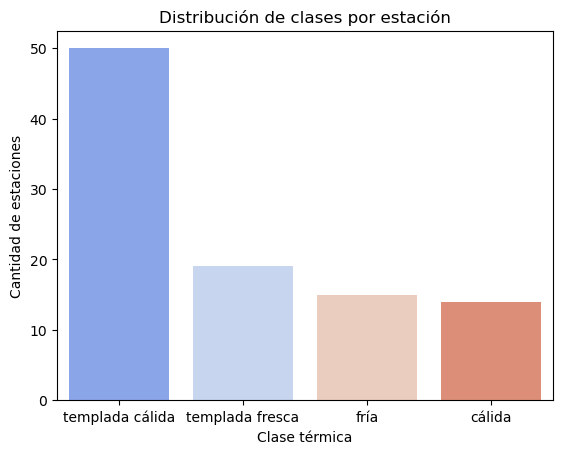

In [31]:
sns.countplot(data=df_temperatura_estacion, x="CLASE", hue="CLASE", palette="coolwarm", legend=False)
plt.title("Distribución de clases por estación")
plt.xlabel("Clase térmica")
plt.ylabel("Cantidad de estaciones")
plt.show()

Para corregir este sobremuestreo elegimos aplicar sobremuestreo con SMOTE a las clases minoritarias en lugar de un submuestreo de la clase mayoritaria ya que nos permite conservar mayor cantidad de datos y ayuda a evitar el overfitting. 

Primero imputamos los valores faltantes y transformamos las variables categóricas en los pipelines.

In [34]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Definimos variables numéricas excluyendo las variables de temperatura (target implícito)
numericas = df_final.select_dtypes(include='number').columns.tolist()

# Pipelines para imputación y encoding
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer para las variables numéricas
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numericas)
])

# Dividimos el dataset antes del preprocesamiento para evitar el data leakage
X = df_final.drop(columns=["CLASE"])
y = df_final["CLASE"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Ajustamos sólo con el set de entrenamiento
preprocessor.fit(X_train)

# Obtenemos los nombres de los features transformados
feature_names = preprocessor.get_feature_names_out()

#Transformamos
X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# SMOTE sobre el set de entrenamiento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_prep, y_train)

print(y_train_res.value_counts())

CLASE
templada cálida    40
fría               40
cálida             40
templada fresca    40
Name: count, dtype: int64


Luego de aplicar SMOTE sobre el set de entrenamiento vemos que ahora se logró una distribución balanceada de clases (40 estaciones cada una), esto proporciona una buena base para el posterior entrenamiento del modelo. Nótese que en lugar de obtener 50 estaciones por clase, al haber hecho la división de 80/20 antes de SMOTE la clase mayoritaria pasó a tener 40 ítems, eso explica este número para las demás clases.

 

--- 
## Análisis y selección de features

Ahora vamos a identificar qué variables son más relevantes para predecir la variable target dado que ya tenemos el set X_train_res (balanceado y preprocesado) y y_train_res.

Para evaluar la relevancia de los atributos predictivos respecto a la variable objetivo CLASE, vamos a aplicar ANOVA y Información Mutua. 

**ANOVA**

C:\Users\matim\AppData\Local\Temp\ipykernel_9384\2623732123.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_anova, x="ANOVA", y="Feature", palette="Blues_d")


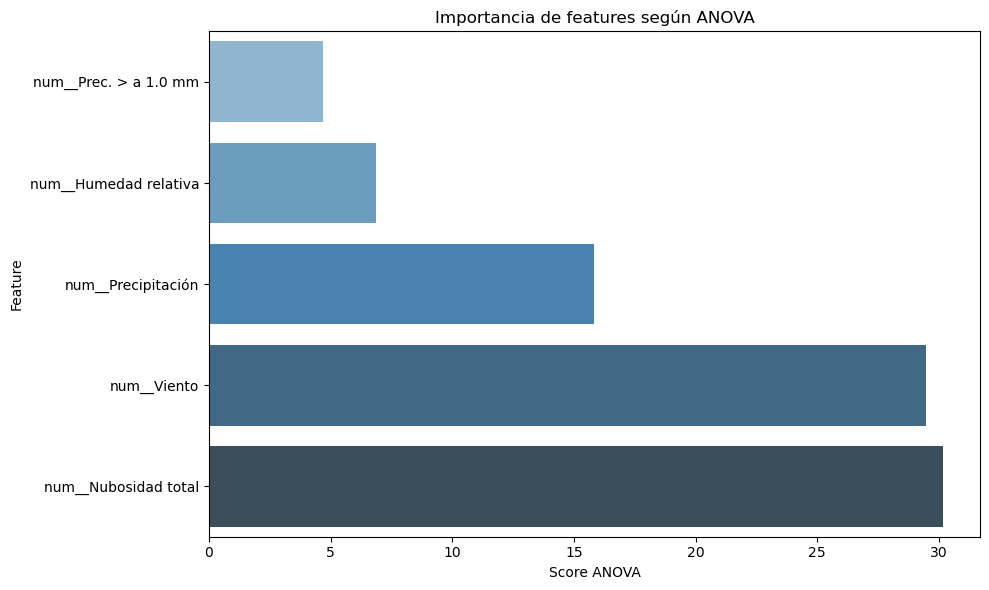

In [37]:
from sklearn.feature_selection import SelectKBest, f_classif

# ANOVA
anova_selector = SelectKBest(score_func=f_classif, k='all')
anova_selector.fit(X_train_res, y_train_res)
anova_scores = anova_selector.scores_

# Gráfico ANOVA
df_anova = pd.DataFrame({
    "Feature": feature_names,
    "ANOVA": anova_scores
}).sort_values(by="ANOVA", ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_anova, x="ANOVA", y="Feature", palette="Blues_d")
plt.title("Importancia de features según ANOVA")
plt.xlabel("Score ANOVA")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Puede verse en base al análisis de ANOVA que las variables que mejor pueden ayudar en la predicción de nuestro modelo son Nubosidad Total y Viento. Esto puede deberse a que las zonas frías suelen tener mayor nubosidad, mientras que las zonas cálidas suelen tener cielos más despejados. El viento también está relacionado con la temperatura: en zonas frías, los vientos son generalmente más intensos y persistentes.

Las precipitaciones tienen menos incidencia en la predicción (cerca de 15 en este Test) pero como vimos en la primera parte de este Trabajo Práctico suele haber una correlación entre las mismas y las temperaturas (a mayores temperaturas, mayores lluvias).

**Información Mutua**

C:\Users\matim\AppData\Local\Temp\ipykernel_9384\467471640.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_mi, x="InfoMutua", y="Feature", palette="Oranges_d")


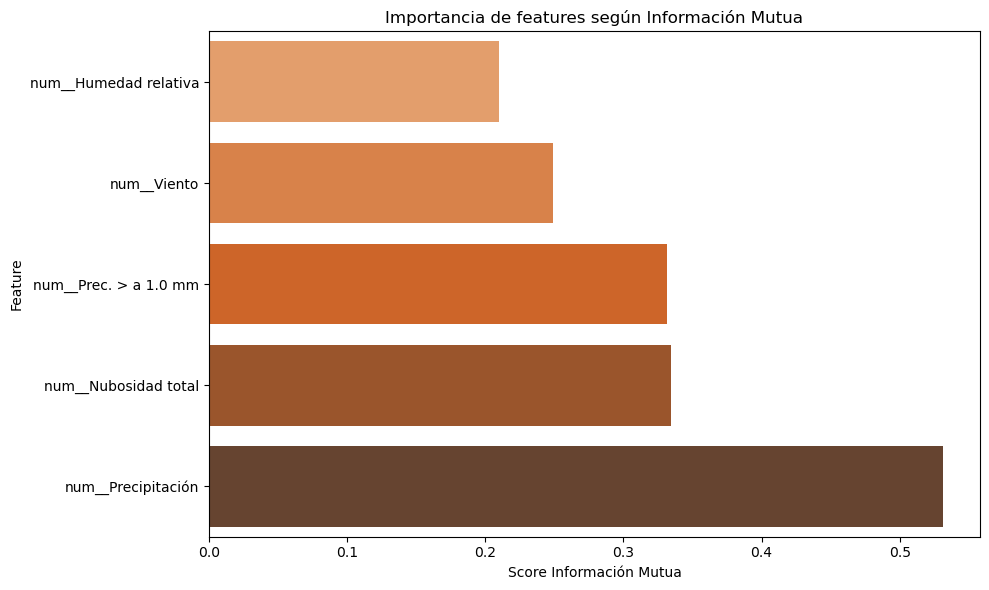

In [38]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Información Mutua
mi_selector = SelectKBest(score_func=mutual_info_classif, k='all')
mi_selector.fit(X_train_res, y_train_res)
mi_scores = mi_selector.scores_

# Gráfico Información Mutua
df_mi = pd.DataFrame({
    "Feature": feature_names,
    "InfoMutua": mi_scores
}).sort_values(by="InfoMutua", ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_mi, x="InfoMutua", y="Feature", palette="Oranges_d")
plt.title("Importancia de features según Información Mutua")
plt.xlabel("Score Información Mutua")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

A diferencia de con ANOVA, donde Nubosidad y Viento fueron los más relevantes, en Información Mutua la variable más informativa fue Precipitación, seguida por Nubosidad y Prec. > a 1 mm. Esto sugiere que, aunque no hay grandes diferencias de medias entre clases, sí hay una dependencia estadística entre la cantidad de precipitación y el tipo de clima, posiblemente en patrones más complejos o no lineales. Como ya marcamos que vimmos en el tarbajo anterior.

--- 
## Selección de features

Para seleccionar los features nos guiamos en los resultados de los tests que acabamos de realizar.

Estas serán las siguientes variables:

Nubosidad total → alta relevancia tanto en ANOVA como en Información Mutua.

Precipitación → destaca principalmente en Información Mutua.

Viento → muy relevante en ANOVA, y aceptable en Información Mutua.


In [39]:
# Lista de features seleccionadas
features_seleccionadas = [
    'num__Nubosidad total',
    'num__Precipitación',
    'num__Viento'
]

Esta reducción de dimensionalidad mantendrá la capacidad predictiva del modelo y mejorará su interpretabilidad. 

No consideramos necesario crear nuevos features.